In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras


import numpy as np
import os

In [6]:
# Disable those annoying warnings
tf.get_logger().setLevel('ERROR')

# Turn off GPU usage for tf
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
os.environ["TF_CPP_MIN_LOG_LEVEL"] = '2'

### Import the data file into a pandas dataframe for some investigation

In [3]:
#df = pd.read_csv('cover_data.csv')
#print(df.head())
#print(df.info())
#print(df.columns)

## Define a helper function to prepare the data

In [7]:
from sklearn.preprocessing import StandardScaler

def prep_data(df):
    """
    prepare data that can be readily consumed by ML
    """
    raw_data = df.values
    X = raw_data[:, :-1]
    y = raw_data[:, -1]

    # split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=7)

    # normalize the data
    scaler = StandardScaler()
    X_train_norm = scaler.fit_transform(X_train)
    X_test_norm = scaler.transform(X_test)
    return X_train_norm, X_test_norm, y_train, y_test  

    

## Define a function that designs the Model

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import InputLayer, Dense, Dropout


def design_model(X_train):
    """
    build the model architecture and compile it
    input: num_features
    output: keras model object
    """
    model = Sequential()
    model.add(InputLayer(input_shape=(X_train.shape[1],)))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(8, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model  

## Compute a confusion table to provide data for a heat map

In [22]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def heat_map(class_names, y_pred, y_test):
    """
    Compute a confusion matrix and use the matrix to plot a heatmap
    input: class_names, y_predicted, y_test
    output: a png file of the heatmap
    """
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(15, 15))
    heatmap = sns.heatmap(cm, fmt='g', cmap='Blues', annot=True, ax=ax, xticklabels=class_names, yticklabels=class_names)

    ax.set_xlabel('Predicted class')
    ax.set_ylabel('True class')
    ax.set_title('Confusion')

       # save heatmap to file
    heatmapfig = heatmap.get_figure()
    heatmapfig.savefig(f'./confusion_matrix.png')   

## Define a function to monitor the performance over several epochs

In [23]:
def plot_history(history, param):
    if param == 'acc':
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()
    elif param == 'loss':
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()

## Write the main function to tie it all together

In [24]:
import sweetviz as sv
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report

def main ():
    raw_df = pd.read_csv('cover_data.csv')

    # EDA
    # uncomment the two lines below to run EDA this takes more than 10 mins
    # my_report = sv.analyze(raw_df)
    # my_report.show_html()

    cols = raw_df.columns.tolist()
    features = cols[:-1]
    labels = cols[-1]
    X_train, X_test, y_train, y_test = prep_data(raw_df)

    # Build a DL model
    model = design_model(X_train)
    print('Summary report of my model: ')
    model.summary()

    num_epochs = 100
    batch_size = 1024
    early_stop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=3)
    history = model.fit(
        X_train,
        y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        callbacks=[early_stop_callback],
        validation_split=0.1,
        verbose=1
    )

    plot_history(history, 'acc')
    plot_history(history, 'loss')

    score = model.evaluate(X_test, y_test, verbose=0)
    print(f'Test loss: {score[0]}')
    print(f'Test accuracy: {score[1]}')

    y_pred = model.predict(X_test)

    # Convert the pred to discrete values
    y_pred = np.argmax(y_pred, axis=1)
    class_names = ['Spruce/Fir', 'Lodgepole Pine', 'Ponderosa Pine', 'Cottonwood/Willow', 'Aspen', 'Douglas-fir', 'Krummholz']
 
    
    print(classification_report(y_test, y_pred, target_names=class_names))
    heat_map(class_names, y_pred, y_test)

Summary report of my model: 
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 32)                1760      
                                                                 
 dense_9 (Dense)             (None, 8)                 264       
                                                                 
Total params: 2024 (7.91 KB)
Trainable params: 2024 (7.91 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
409/409 [==============================] - 1s 1ms/step - loss: 0.9787 - accuracy: 0.6099 - val_loss: 0.6907 - val_accuracy: 0.7146
Epoch 2/100
409/409 [==============================] - 0s 1ms/step - loss: 0.6593 - accuracy: 0.7258 - val_loss: 0.6306 - val_accuracy: 0.7363
Epoch 3/100
409/409 [==============================] - 0s 1ms/step - loss: 0.6218 - accuracy: 0.7375 - 

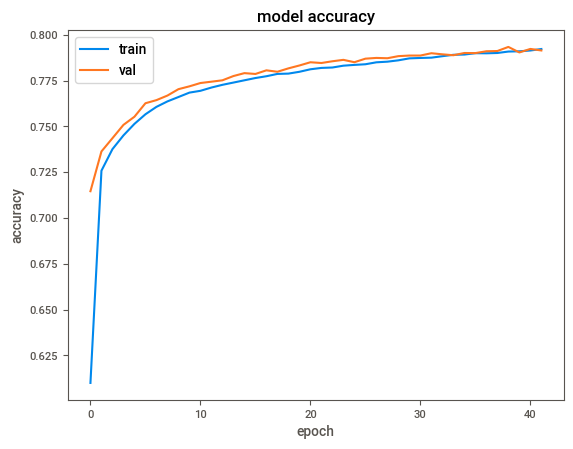

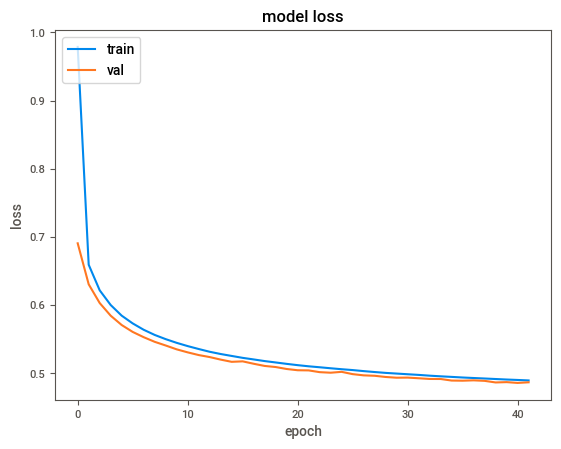

Test loss: 0.48961198329925537
Test accuracy: 0.7911930084228516
3632/3632 [==============================] - 2s 674us/step
                   precision    recall  f1-score   support

       Spruce/Fir       0.80      0.77      0.78     42524
   Lodgepole Pine       0.80      0.85      0.83     56386
   Ponderosa Pine       0.74      0.82      0.78      7185
Cottonwood/Willow       0.83      0.56      0.67       600
            Aspen       0.70      0.21      0.33      1905
      Douglas-fir       0.56      0.41      0.47      3456
        Krummholz       0.83      0.74      0.78      4147

         accuracy                           0.79    116203
        macro avg       0.75      0.62      0.66    116203
     weighted avg       0.79      0.79      0.79    116203



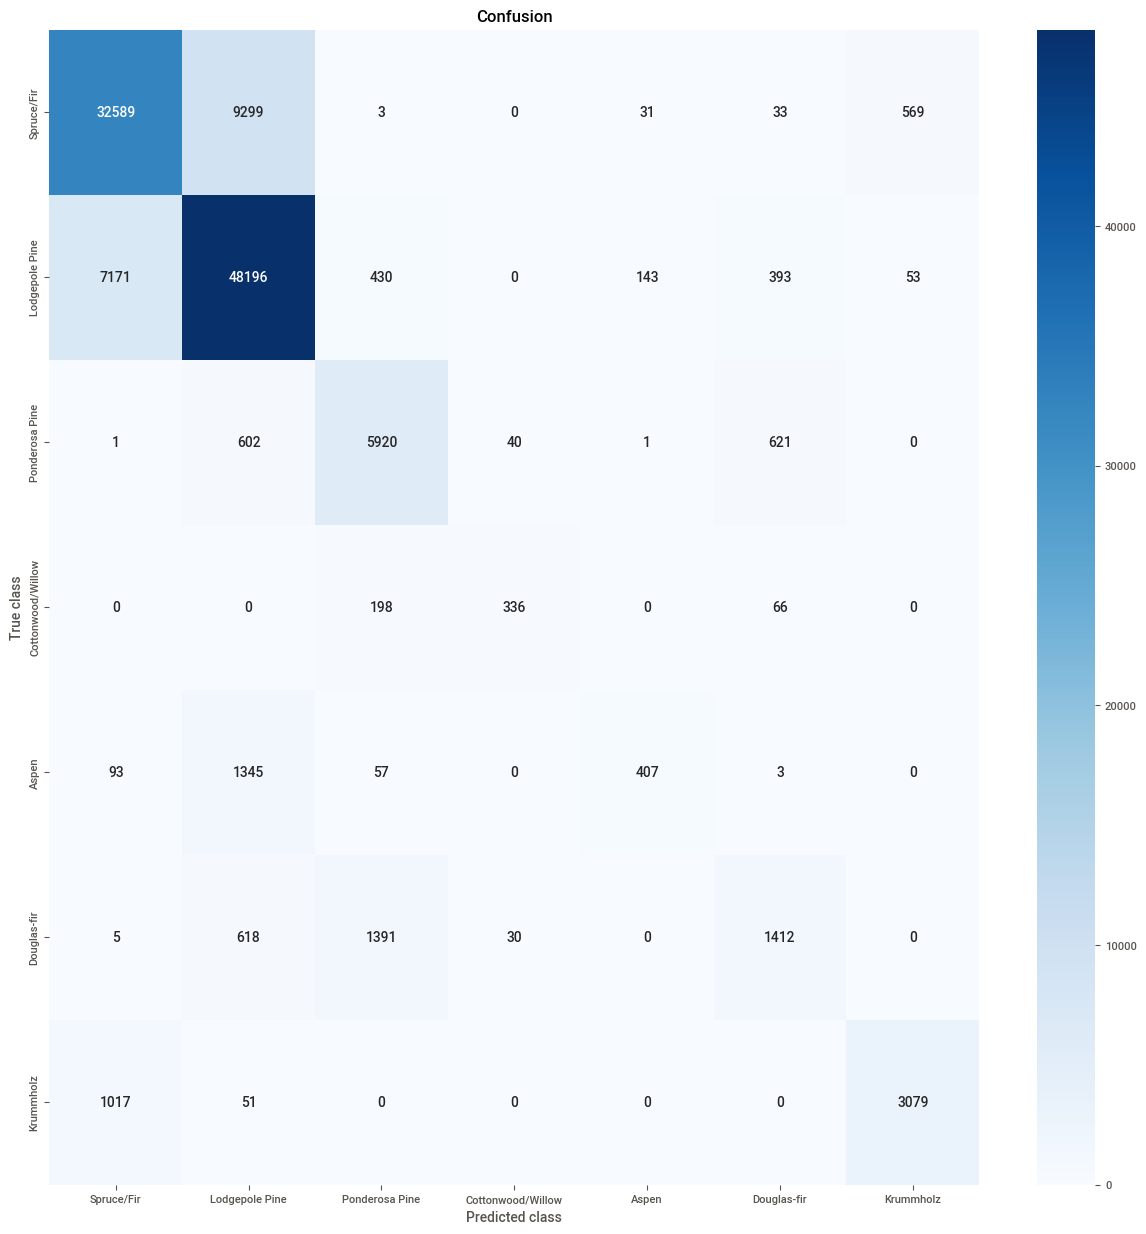

In [25]:
if __name__ == '__main__':
    main()